# Blight Violations in the City of Detroit

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Applied_Data_Science_with_Python_Specialization/portfolio-4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Predict whether a given blight ticket will be paid on time.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report, roc_curve
import folium
import seaborn as sns
sns.set_style('whitegrid')

## Load the dataset

In [2]:
data_url = 'https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Applied_Data_Science_with_Python_Specialization/main/Applied_Machine_Learning_in_Python/Week4/Labs/data/train.csv.gz'
df_data = pd.read_csv(data_url, encoding="ISO-8859-1", low_memory=False)
df_data.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [3]:
addresses_url = 'https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Applied_Data_Science_with_Python_Specialization/main/Applied_Machine_Learning_in_Python/Week4/Labs/data/addresses.csv.gz'
df_addresses = pd.read_csv(addresses_url)
df_addresses.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [4]:
latlons_url = 'https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Applied_Data_Science_with_Python_Specialization/main/Applied_Machine_Learning_in_Python/Week4/Labs/data/latlons.csv'
df_latlons = pd.read_csv(latlons_url)
df_latlons.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


## Understand the dataset

[Blight violations](https://data.detroitmi.gov/datasets/detroitmi::blight-violations/about) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process.

Each row of the dataset corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible.

File descriptions:

- train.csv -> the dataset (all tickets issued 2004-2011)
- addresses.csv & latlons.csv -> mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 

Data fields:

- ticket_id -> unique identifier for tickets
- agency_name -> Agency that issued the ticket
- inspector_name -> Name of inspector that issued the ticket
- violator_name -> Name of the person/organization that the ticket was issued to
- violation_street_number, violation_street_name, violation_zip_code -> Address where the violation occurred
- mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country -> Mailing address of the violator
- ticket_issued_date -> Date and time the ticket was issued
- hearing_date -> Date and time the violator's hearing was scheduled
- violation_code, violation_description -> Type of violation
- disposition -> Judgment and judgement type
- fine_amount -> Violation fine amount, excluding fees
- admin_fee -> $20 fee assigned to responsible judgments
- state_fee -> $10 fee assigned to responsible judgments
- late_fee -> 10% fee assigned to responsible judgments
- discount_amount -> discount applied, if any
- clean_up_cost -> DPW clean-up or graffiti removal cost
- judgment_amount -> Sum of all fines and fees
- grafitti_status -> Flag for graffiti violations
- payment_amount -> Amount paid, if any
- payment_date -> Date payment was made, if it was received
- payment_status -> Current payment status as of Feb 1 2017
- balance_due -> Fines and fees still owed
- collection_status -> Flag for payments in collections
- compliance [target variable for prediction] 
    - Null = Not responsible
    - 0 = Responsible, non-compliant
    - 1 = Responsible, compliant
- compliance_detail -> More information on why each ticket was marked compliant or non-compliant

**Note**: All tickets where the violators were found not responsible are not considered.

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [6]:
df_addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311307 entries, 0 to 311306
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ticket_id  311307 non-null  int64 
 1   address    311307 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.8+ MB


In [7]:
df_latlons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121769 entries, 0 to 121768
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  121769 non-null  object 
 1   lat      121762 non-null  float64
 2   lon      121762 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB


## Merge the dataset

In [8]:
df = df_data.merge(df_addresses.merge(df_latlons, on="address"), on="ticket_id")
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


## Preprocess the dataset

In [9]:
drop_columns = ['ticket_id', 'inspector_name', 'violator_name', 'violation_street_number', 'violation_street_name', 'violation_zip_code', 
                'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'non_us_str_code', 'country', 'ticket_issued_date', 
                'hearing_date', 'violation_description', 'violation_code', 'admin_fee', 'state_fee', 'clean_up_cost', 'grafitti_status', 'payment_amount', 
                'balance_due', 'payment_date', 'collection_status', 'compliance_detail', 'address']

df_reduced = df[df['country'] == "USA"].drop(drop_columns, axis=1).dropna()
df_reduced.head()

,agency_name,disposition,fine_amount,late_fee,discount_amount,judgment_amount,payment_status,compliance,lat,lon
0,"Buildings, Safety Engineering & Env Department",Responsible by Default,250.0,25.0,0.0,305.0,NO PAYMENT APPLIED,0.0,42.390729,-83.124268
1,"Buildings, Safety Engineering & Env Department",Responsible by Determination,750.0,75.0,0.0,855.0,PAID IN FULL,1.0,42.326937,-83.135118
5,"Buildings, Safety Engineering & Env Department",Responsible by Default,250.0,25.0,0.0,305.0,NO PAYMENT APPLIED,0.0,42.145257,-83.208233
6,"Buildings, Safety Engineering & Env Department",Responsible by Default,750.0,75.0,0.0,855.0,NO PAYMENT APPLIED,0.0,42.433466,-83.023493
7,"Buildings, Safety Engineering & Env Department",Responsible by Default,100.0,10.0,0.0,140.0,NO PAYMENT APPLIED,0.0,42.388641,-83.037858


In [10]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159867 entries, 0 to 250293
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   agency_name      159867 non-null  object 
 1   disposition      159867 non-null  object 
 2   fine_amount      159867 non-null  float64
 3   late_fee         159867 non-null  float64
 4   discount_amount  159867 non-null  float64
 5   judgment_amount  159867 non-null  float64
 6   payment_status   159867 non-null  object 
 7   compliance       159867 non-null  float64
 8   lat              159867 non-null  float64
 9   lon              159867 non-null  float64
dtypes: float64(7), object(3)
memory usage: 13.4+ MB


## Visualize the class distribution

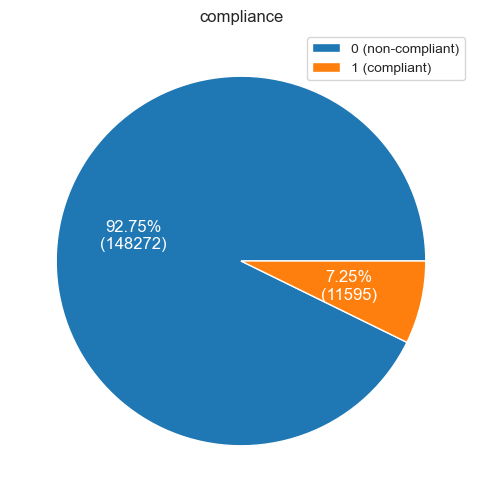

In [11]:
labels, sizes = np.unique(df_reduced["compliance"], return_counts=True)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, textprops={'fontsize': '12', 'color': 'w'}, autopct=lambda pct: "{:.2f}%\n({:d})".format(pct, round(pct/100 * sum(sizes))))
ax.legend(["1 (compliant)" if i else "0 (non-compliant)" for i in labels])
ax.set_title("compliance")
plt.show()

## Visualize the location of some samples

Red markers mean `compliant`, while blue markers mean `non-compliant`.

In [12]:
map = folium.Map(location=[42.36, -83.10], zoom_start=12)
feature_group = folium.FeatureGroup()
df_sample = df_reduced.sample(n=1000)

for point, compliance in zip(list(df_sample[["lat", "lon"]].to_numpy()), list(df_sample["compliance"])):
    if compliance == 1:
        feature_group.add_child(folium.Marker(point, popup='compliant', icon=folium.Icon(color='red')))
    else:
        feature_group.add_child(folium.Marker(point, popup='non-compliant', icon=folium.Icon(color='blue')))

map.add_child(feature_group)
map

## Convert categorical variable into indicator variables

In [13]:
df_reduced = pd.get_dummies(df_reduced, drop_first=True)
df_reduced.head()

,fine_amount,late_fee,discount_amount,judgment_amount,compliance,lat,lon,agency_name_Department of Public Works,agency_name_Detroit Police Department,agency_name_Health Department,agency_name_Neighborhood City Halls,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,payment_status_PAID IN FULL,payment_status_PARTIAL PAYMENT APPLIED
0,250.0,25.0,0.0,305.0,0.0,42.390729,-83.124268,False,False,False,False,False,True,False,False,False
1,750.0,75.0,0.0,855.0,1.0,42.326937,-83.135118,False,False,False,False,False,False,True,True,False
5,250.0,25.0,0.0,305.0,0.0,42.145257,-83.208233,False,False,False,False,False,True,False,False,False
6,750.0,75.0,0.0,855.0,0.0,42.433466,-83.023493,False,False,False,False,False,True,False,False,False
7,100.0,10.0,0.0,140.0,0.0,42.388641,-83.037858,False,False,False,False,False,True,False,False,False


## Split the dataset into train and test subsets

In [14]:
X = df_reduced.drop("compliance", axis=1)
y = df_reduced["compliance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (119900, 15)
X_test shape: (39967, 15)


##  Train a Random Forest classifier

In [15]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

## Evaluate the model

              precision    recall  f1-score   support

         0.0     0.9687    0.9839    0.9762     37064
         1.0     0.7428    0.5939    0.6600      2903

    accuracy                         0.9556     39967
   macro avg     0.8557    0.7889    0.8181     39967
weighted avg     0.9523    0.9556    0.9533     39967



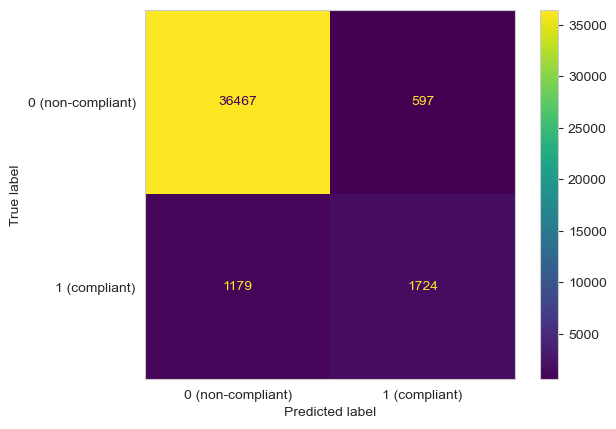

In [16]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (non-compliant)", "1 (compliant)"])
plt.grid(False)
plt.show()

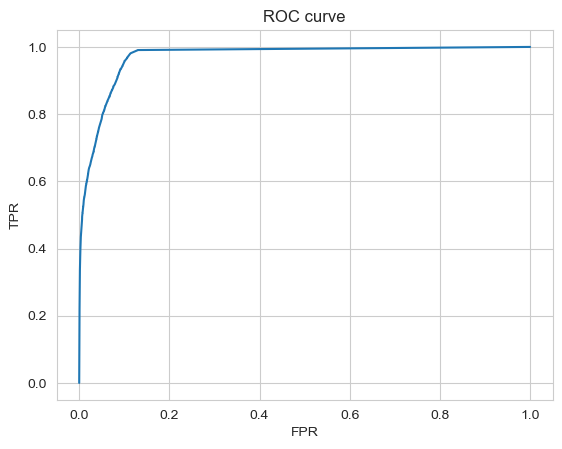

In [17]:
y_proba = classifier.predict_proba(X_test)[:, -1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()